<a href="https://colab.research.google.com/github/abdellah-idris/NLI/blob/master/named_entity_recognition_(NER).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notes et Objectif



**Session1**
- Features and processing

**Session 2**
- train - dev- test- test
  
**Session3**

- Evaluation:  
    - precision rappel roc curve
    - Accuracy: a quelle point il a raison
    - F1-score: better to comprae models

    - Classification multi classes:
      - **macro f1:** Arithmetic ( harmonic (P,R)),  harmonic( Arithmetic(P,R))
        - all classes same weight
      - micro f1:  harmonic(Pbis,Rbis):
        - utilisé quand on a une classe dominante, ce qui permet d'viter de parler des autres classes

  **Use macro: Arithmetic ( harmonic (P,R))**

  **Session4**:
  - Classification thématique
  - Ecq on a pas une structure spécifique à chaque langue
  2 approches completement différentes :
  - prédire à la fois la famille de langue + la langue => ca marche pas
  - prédire la famille puis la langue **avec un modèle différent** (Pour HIN et TEL => classsification binaire ... etc )

 - Le nombre d'échantillons peut etre important (selon le modèle choisi)
 - Entrainer le modèle M1 par cross validation




**Objectif du projet**:

L'objectif principal de ce projet est de créer un modèle robuste et précis capable d'identifier avec une fiabilité élevée la langue maternelle d'un individu en se basant sur ses performances à l'examen TOEIC.


À travers ce projet, nous explorerons les différentes techniques de prétraitement des données, de sélection de caractéristiques et d'apprentissage automatique afin de développer un modèle robuste et généralisable.



# Chargement des données

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [ ]:
from google.colab import files

uploaded = files.upload()

Saving train.txt to train (2).txt


In [ ]:
import os
os.listdir('.')

['.config', 'train (1).txt', 'train (2).txt', 'train.txt', 'sample_data']

# Aquisition des données

#### 1. Lecture des données

In [ ]:
df = pd.read_csv('train.txt', sep='\t', header=None)

In [ ]:
df.shape

(9900, 1)

In [ ]:
df.head()

,0
0,(GER) IThe importance and popularity of travel...
1,"(TUR) It is an important decision , how to pla..."
2,(CHI) Some people believe that young people ca...
3,(TEL) Travelling is usually considered as good...
4,(ARA) i agree that . Life is a person live per...


#### 2. Extraction des labels (langues maternelles)

In [ ]:
import re

def extract_country_and_text(row):
    match = re.match(r'\((.*?)\)(.*)', row)
    if match:
        country_code = match.group(1)
        text = match.group(2)
        return pd.Series([country_code, text])
    else:
        return pd.Series(['', row])

df[['country_code', 'text']] = df.iloc[:, 0].apply(extract_country_and_text)

df['country_code'].value_counts()

GER    900
TUR    900
CHI    900
TEL    900
ARA    900
SPA    900
HIN    900
JPN    900
KOR    900
FRE    900
ITA    900
Name: country_code, dtype: int64

In [ ]:
df.dropna(subset=['country_code'], inplace=True)
df.shape
# All texts are labeled

(9900, 3)

In [ ]:
df.head()

,0,country_code,text
0,(GER) IThe importance and popularity of travel...,GER,IThe importance and popularity of travelling ...
1,"(TUR) It is an important decision , how to pla...",TUR,"It is an important decision , how to plan you..."
2,(CHI) Some people believe that young people ca...,CHI,Some people believe that young people can enj...
3,(TEL) Travelling is usually considered as good...,TEL,Travelling is usually considered as good recr...
4,(ARA) i agree that . Life is a person live per...,ARA,i agree that . Life is a person live period o...


#### **Remarques**
- Nous disposons de **11 langues** d'origines différentes, chacune associée à **900 observations** de textes.
- Tous les textes sont annotés.

# Analyse Exploratoire des Données (EDA)

### 1. **Distribution de la longueur des phrases pour les différentes langues**

In [ ]:
# Ajout d'une colonne pour stocker la longueur du texte
df['length_text'] = df['text'].apply(lambda x: len(str(x)))

In [ ]:
import plotly.express as px

# Boites à moustaches
fig = px.box(df, x = 'country_code', y = 'length_text')
fig.update_layout(
    title="Longueurs des phrases par langue",
    xaxis_title="Langues",
    yaxis_title="Longueurs des phrases",
    title_x=0.5
)

fig

 **Analyse**

- Les diagrammes en boîte montrent que les longueurs médianes des phrases sont presque similaires à travers les différentes langues.
- Ceci indique que la longueur des phrases n’est pas un indicateur fiable pour distinguer les langues maternelles car elle ne varie pas assez entre les langues.




### 2. **Nuages de mots pour chaque langue**

---



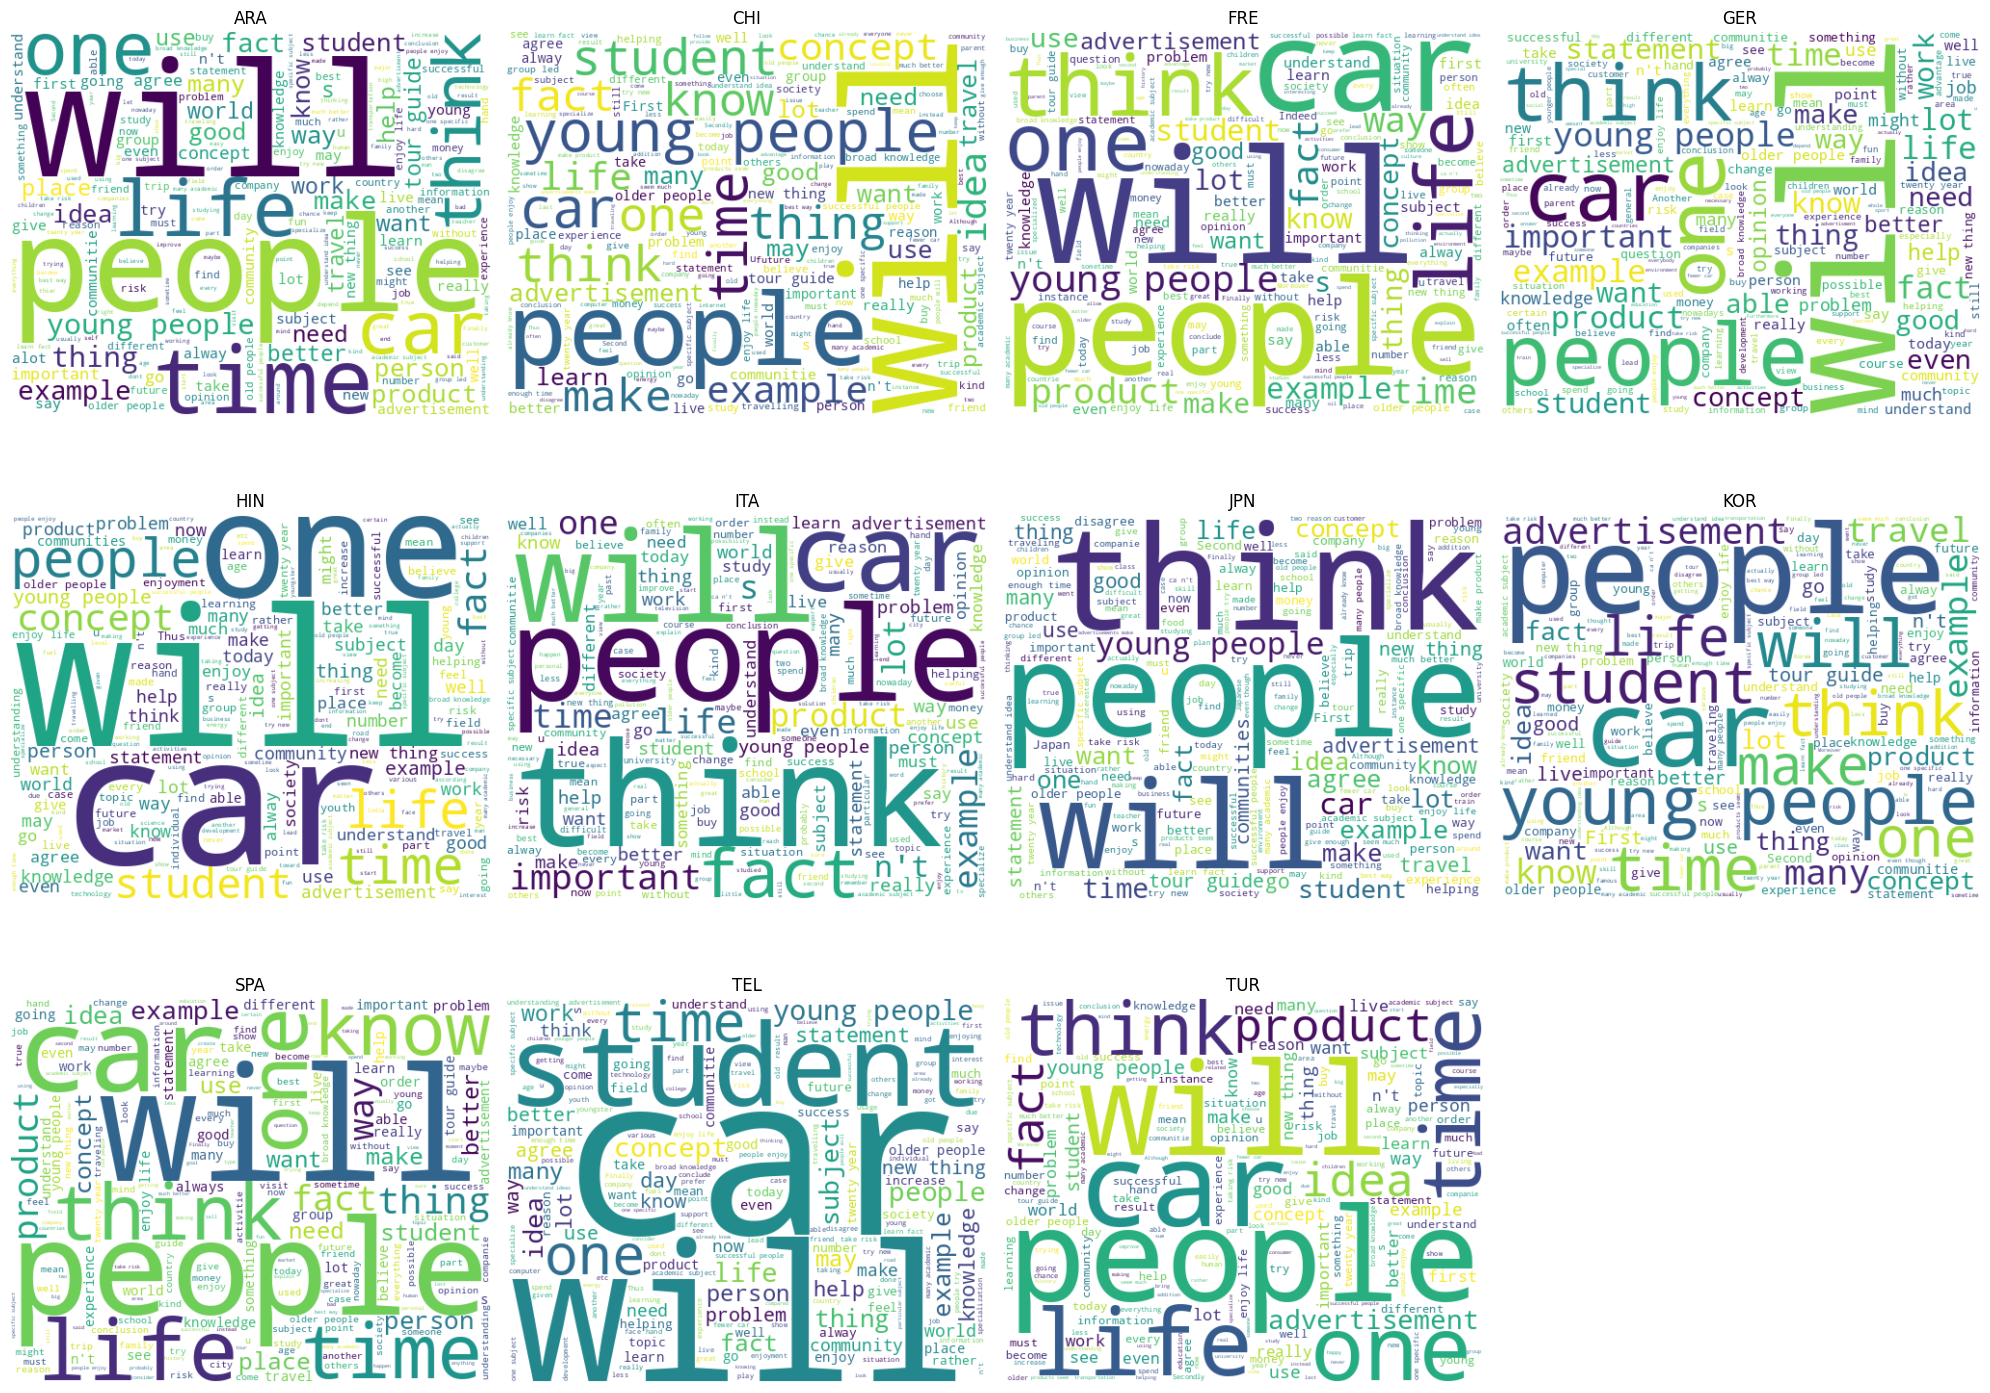

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

fig, axes = plt.subplots(3, 4, figsize=(20, 15))

# Parcourir les groupes de données groupés par le code de pays
for (country_code, group), ax in zip(df.groupby('country_code'), axes.flatten()):

    # Concaténer tous les textes du groupe et générer le nuage de mots
    text = ' '.join(group['text'])
    wordcloud = WordCloud(width=500, height=400, background_color='white').generate(text)

    # Afficher le nuage de mots
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(country_code)
    ax.axis('off')

fig.delaxes(axes.flatten()[-1])

plt.tight_layout()
plt.show()

 **Analyse**

- Certains mots, tels que "people", "think", "time", "car", "student", et "life", sont très présents dans presque tous les nuages.

- On peut supposer que le sujets discutés par les participants sont similaires.

- Ces mots communs ne vont donc pas servir de caractéristiques utiles pour identifier la langue maternelle.

### 3. **Fréquence moyenne de ponctuation par langue**

In [ ]:
import pandas as pd
import string

# Fonction pour calculer la fréquence de ponctuation
def compute_punctuation_frequency(text):
    total_chars = sum(1 for char in text if char not in string.whitespace)
    punctuation_count = sum(1 for char in text if char in string.punctuation)
    return punctuation_count / total_chars * 100 if total_chars > 0 else 0

# Ajouter une colonne pour la fréquence de ponctuation
df['punctuation_frequency'] = df['text'].apply(compute_punctuation_frequency)

In [ ]:
import plotly.express as px

# Calculer la fréquence moyenne de ponctuation par pays
punctuation_freq_by_country = df.groupby('country_code')['punctuation_frequency'].mean().reset_index()

fig = px.bar(punctuation_freq_by_country, x='country_code', y='punctuation_frequency')
fig.update_layout(
    title="Fréquence moyenne de ponctuation par langue",
    xaxis_title="Langue",
    yaxis_title="Fréquence de ponctuation (%)",
    title_x=0.5
)

fig

**Analyse**
- On constate des variations entre les langues:

  - Les japonais (JPN), les coréens (KOR) et les chinois (CHI) utilisent la ponctuation plus fréquemment.

  - Les locuteurs de Hindi (HIN) et de Telougou (TEL) ont les fréquences moyennes de ponctuation les plus basses.

- On peut donc supposer que la façon dont les participants utilisent la ponctuation en anglais est influencée par les règles grammaticales des langues maternelles.

- La fréquence de la ponctuation pourrait donc servir de caractéristique pertinente pour distinguer les écrits des différentes personnes.


### 4. **Fréquence des caractères de ponctuation par langue**

In [ ]:
import pandas as pd

punctuation = ['.', '?', '!', ',', ';', ':', '…', '(', ')', '[', ']', '«', '»', '—', '/']

# grouper puis concaténer les textes de chaque langue
df_punctuation = df.groupby(['country_code'])['text'].apply(''.join).reset_index()

# Compter le nombre d'occurrences de chaque caractère de ponctuation
for p in punctuation:
    df_punctuation[p] = df_punctuation['text'].apply(lambda x: x.count(p))

df_punctuation = df_punctuation.drop(columns=['text'])

df_punctuation.head()

,country_code,.,?,!,",",;,:,…,(,),[,],«,»,—,/
0,ARA,10823,268,94,9359,130,137,0,101,108,3,1,0,0,0,127
1,CHI,15703,436,93,15713,133,108,0,38,38,1,1,0,0,0,83
2,FRE,14405,517,198,13520,186,450,0,180,181,6,6,0,0,0,38
3,GER,15691,387,136,10262,50,299,0,179,180,0,0,0,0,0,62
4,HIN,15835,208,94,8913,60,52,0,125,125,1,1,0,0,0,189


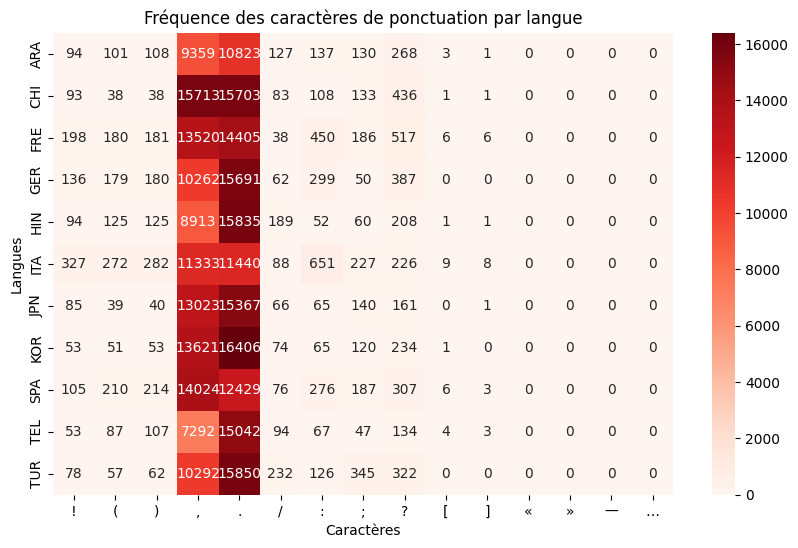

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Créer la heatmap avec Matplotlib
plt.figure(figsize=(10, 6))
heatmap_data = pd.pivot_table(df_punctuation, values=punctuation, index=['country_code'], aggfunc=np.sum)
sns.heatmap(heatmap_data, cmap='Reds', annot=True, fmt='.0f')

plt.title("Fréquence des caractères de ponctuation par langue")
plt.xlabel("Caractères")
plt.ylabel("Langues")
plt.show()


 **Analyse**

- Sans grosse surprise, les caractères les plus utilisés sont le point '.' et la virgule ',' pour l'ensemble des langues ce qui diminue leur utilité en tant qu'indicateurs spécifiques d'une langue particulière.
- Les autres caractères de ponctuation apparaissent avec des fréquences plus basses et ne montrent pas de tendances claires qui pourraient être exploitées.


### 5. **Stop Words**

In [ ]:
import plotly.express as px
import matplotlib.pyplot as plt
import pandas as pd
import nltk
from nltk.corpus import stopwords
from collections import Counter
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

#### Fréquence Moyenne des stop words par langue

In [ ]:
# Chargement de la liste des stop words pour l'anglais
stop_words = set(stopwords.words('english'))

# Fonction pour calculer la fréquence des stop words par texte
def compute_stopword_frequency(text):
    # Tokenisation du texte en mots
    words = nltk.word_tokenize(text)
    total_words = len(words)
    stopword_count = sum(1 for word in words if word.lower() in stop_words)

    # Calcul de la fréquence des stop words (nombre de stop words / nombre total de mots)
    if total_words > 0:
        return stopword_count / total_words *100
    else:
        return 0

# Ajouter une colonne pour la fréquence moyenne des stop words par texte
df['stopword_frequency'] = df['text'].apply(compute_stopword_frequency)

In [ ]:
import plotly.express as px

# Calculer la fréquence moyenne des stop words par langue
punctuation_freq_by_country = df.groupby('country_code')['stopword_frequency'].mean().reset_index()

fig = px.bar(punctuation_freq_by_country, x='country_code', y='stopword_frequency')
fig.update_layout(
    title="Fréquence moyenne des stop words par langue",
    xaxis_title="Langue",
    yaxis_title="Fréquence de stop words(%)",
    title_x=0.5
)

fig

 **Analyse**

- La fréquence des stop words est relativement stable à travers toutes les langues.
- Ainsi, malgré les différentes langues maternelles, les participants ont tendance à inclure un nombre similaire de stop words.


Essayons de détailler un peu en affichant la fréquence des 10 Tops Stop Words par langue:

#### Fréquence des Top 10 stop words par langue

In [ ]:
# Charger la liste des stop words pour l'anglais
stop_words = set(stopwords.words('english'))

def count_stopwords(text):
    # Tokenisation des mots
    words = nltk.word_tokenize(text.lower())

    # Compter la fréquence des stopwords dans le texte
    stopwords_freq = Counter([word for word in words if word in stop_words])
    return stopwords_freq

stopwords_freq_by_language = {}
for country_code, group in df.groupby('country_code'):
    # Concaténer tous les textes par langue
    concatenated_text = ' '.join(group['text'])

    # Compter la fréquence des stopwords pour chaque langue
    stopwords_freq_by_language[country_code] = count_stopwords(concatenated_text)

In [ ]:
for country_code, stopwords_freq in stopwords_freq_by_language.items():
    print(f"{country_code}: {stopwords_freq}")

ARA: Counter({'the': 12252, 'to': 9233, 'and': 7997, 'in': 6016, 'a': 5419, 'of': 5337, 'that': 4862, 'is': 4418, 'i': 3430, 'it': 3319, 'they': 3077, 'for': 2889, 'you': 2681, 'will': 2586, 'are': 2475, 'have': 2415, 'be': 2318, 'not': 2156, 'with': 1963, 'more': 1760, 'this': 1732, 'or': 1711, 'do': 1706, 'can': 1593, 'we': 1507, 'their': 1467, 'as': 1460, 'if': 1255, 'on': 1246, 'he': 1233, 'about': 1151, 'than': 1146, 'but': 1137, 'because': 1135, 'so': 1103, 'them': 1098, 'there': 1036, 'by': 1023, 'my': 1011, 'all': 974, 'what': 960, 'from': 943, 'some': 941, 'when': 856, 'other': 796, 'his': 741, 'an': 726, 'who': 664, 'which': 645, 'your': 636, 'any': 597, 'how': 569, 'our': 541, 'very': 535, 'most': 526, 'at': 515, 'should': 485, 'has': 477, 'was': 477, 'these': 457, 'only': 397, 'no': 392, 'me': 351, 'its': 329, 'having': 326, 'just': 306, 'then': 292, 'such': 278, 'him': 269, 'where': 263, 'same': 255, 'doing': 250, 'now': 249, 'being': 240, 'out': 234, 'after': 226, 'up': 2

In [ ]:
# Initialisation d'une liste pour stocker les données
stopwords_data = []

for country_code, freq_dict in stopwords_freq_by_language.items():
    # Trier le dictionnaire des fréquences par fréquence décroissante et garder les 10 premiers
    top_10_stopwords = sorted(freq_dict.items(), key=lambda item: item[1], reverse=True)[:10]

    for stop_word, freq in top_10_stopwords:
        stopwords_data.append({'country_code': country_code, 'stop_word': stop_word, 'frequency': freq})

# Création du DataFrame
df_stopwords = pd.DataFrame(stopwords_data)


fig = px.scatter(df_stopwords, x="country_code", y="frequency", color="stop_word",
                 labels={"country_code": "Langue",
                         "frequency": "Fréquence",
                         "stop_word": "Stopword"})
fig.update_layout(
    title="Fréquence des 10 top stopwords par langue",
    title_x=0.5
)

fig.show()

**Analyse** :

- On constate des variations dans la fréquence de certains stop words tels que "the", "to", "and", "are", et "you" , … etc

- Ces variations pourraient être exploitées pour détecter des différences subtiles dans l'utilisation de la langue.

### 6. **Fréquence des erreurs d'orthographe**

In [ ]:
!pip install pyspellchecker

from spellchecker import SpellChecker
import re
# Fonction pour compter les fautes d'orthographe dans un texte
spell = SpellChecker()

def count_spelling_errors(text):

    # Utiliser une expression régulière pour trouver tous les mots dans le texte
    words = re.findall(r'\b\w+\b', text.lower())

    # Trouver les mots mal orthographiés
    misspelled = spell.unknown(words)
    return len(misspelled)

# Calcul du nombre de fautes d'orthographe pour chaque texte
df['spelling_errors'] = df['text'].apply(count_spelling_errors)

In [ ]:
df.head()

,0,country_code,text,length_text,punctuation_frequency,stopword_frequency,spelling_errors
0,(GER) IThe importance and popularity of travel...,GER,IThe importance and popularity of travelling ...,1650,1.372998,56.637168,6
1,"(TUR) It is an important decision , how to pla...",TUR,"It is an important decision , how to plan you...",2055,2.168675,50.252525,2
2,(CHI) Some people believe that young people ca...,CHI,Some people believe that young people can enj...,1943,2.658885,47.263682,3
3,(TEL) Travelling is usually considered as good...,TEL,Travelling is usually considered as good recr...,1828,1.227831,53.314917,8
4,(ARA) i agree that . Life is a person live per...,ARA,i agree that . Life is a person live period o...,940,2.257636,45.454545,9


In [ ]:
import plotly.express as px

# Calculer la fréquence moyenne des stop words par langue
punctuation_freq_by_country = df.groupby('country_code')['spelling_errors'].mean().reset_index()

fig = px.bar(punctuation_freq_by_country, x='country_code', y='spelling_errors')
fig.update_layout(
    title="Fréquence moyenne des erreurs d'orthographe par Langue",
    xaxis_title="Langue",
    yaxis_title="Fréquence des erreurs d'orhographe",
    title_x=0.5
)

fig

**Analyse**

- Il y a une variation notable entre les locuteurs de différentes langues maternelles.
- Par exemple, (ARA) a la fréquence d'erreurs d'orthographe la plus élevée, tandis que (TUR) a la fréquence la plus faible.
- (JPN) et (KOR) ont des fréquences presque similaires, ce qui pourrait être dû à des caractéristiques structurelles communes.
- Cette variation indique que la fréquence des erreurs d'orthographe pourrait être une caractéristique utile pour distinguer différentes langues maternelles.

# Hypothèses




- À première vue, il semble que l'ajout de certaines caractéristiques telles que la **longueur des phrases** et l'**utilisation fréquente de mots communs** ne puisse pas apporter une amélioration significative car l'ensemble de ces caractéristiques présente des valeurs très rapprochées entre les différentes langues.

- Cependant, certaines caractéristiques telles que la **fréquence des erreurs d'orthographe**, l'**usage de la ponctuation**, et les variations dans l'emploi des **stop words les plus fréquents** montrent une variabilité plus importante et pourraient se révéler prometteuses.
  - Ces caractéristiques pourraient améliorer les capacités de nos modèles à distinguer entre les différentes langues maternelles.

# Modelisation & Evaluation

- Afin de réaliser notre analyse et tester les différentes hypothèses, nous avons entrepris l'entraînement de modèles de classification en utilisant les 2 algorithmes: **Logistic Regression** et **SVM**.

- Le prétraitement précédant cet entraînement est effectué en suivant les 2 approches **BOW** et **TF-IDF**.

## Utils

In [ ]:
def evaluate_model_performance(model, model_name, method_name, train, test, y_train, y_test):

    model.fit(train, y_train)
    predictions = model.predict(test)

    # Calculating the performance metrics
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions, average='macro')
    recall = recall_score(y_test, predictions, average='macro')
    f1 = f1_score(y_test, predictions, average='macro')

    # Printing the metrics
    print(f"{model_name} ({method_name}) \n- Accuracy: {accuracy:.4f} \n- Precision-macro: {precision:.4f} \n- Recall-macro: {recall:.4f} \n- F1-macro: {f1:.4f}")


In [ ]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def evaluate_model_performance_detailed(mapping_list, model, model_name, method_name, train, test, y_train, y_test):
    model.fit(train, y_train)
    predictions = model.predict(test)

    # Metrics for each label
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, predictions, average=None)
    metrics_df = pd.DataFrame({'Label': list(mapping_list.keys()),
                               'Precision': precision,
                               'Recall': recall,
                               'F1 Score': f1})

    # Global (macro) metrics
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(y_test, predictions, average='macro')
    accuracy = accuracy_score(y_test, predictions)

    print(f"{model_name} ({method_name}) - Overall Metrics:\n- Accuracy: {accuracy:.4f}\n- Precision (Macro): {precision_macro:.4f}\n- Recall (Macro): {recall_macro:.4f}\n- F1 (Macro): {f1_macro:.4f}\n")

    print(f"{model_name} ({method_name}) - Metrics by Label:")
    print(metrics_df.to_string(index=False))


In [ ]:
def display_confusion_matrix(mapping_list, model, model_name, method_name, test, y_test):

    predictions = model.predict(test)
    cm = confusion_matrix(y_test, predictions)

    # Plotting the confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, cmap='coolwarm', fmt='d', xticklabels=list(mapping_list.keys()), yticklabels=list(mapping_list.keys()))
    plt.title(f"Confusion Matrix - {model_name} ({method_name})")
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

## Without features

In [ ]:
vectorizer_BOW = CountVectorizer(max_features = 100000, min_df = 0.1, stop_words='english')
vectorizer_TF_IDF = TfidfVectorizer(max_features = 100000, stop_words='english')

# Modèles de classification
models = {
    'Logistic Regression': LogisticRegression(max_iter=10000),
    'SVM': SVC(kernel='rbf')
}

========================= Without Features=============================
=========================Logistic Regression=============================
Logistic Regression (BOW) - Overall Metrics:
- Accuracy: 0.3621
- Precision (Macro): 0.3624
- Recall (Macro): 0.3652
- F1 (Macro): 0.3610

Logistic Regression (BOW) - Metrics by Label:
Label  Precision   Recall  F1 Score
  GER   0.467456 0.459302  0.463343
  TUR   0.272189 0.273810  0.272997
  CHI   0.333333 0.331429  0.332378
  TEL   0.463918 0.502793  0.482574
  ARA   0.290323 0.370588  0.325581
  SPA   0.324503 0.250000  0.282421
  HIN   0.331522 0.346591  0.338889
  JPN   0.394286 0.370968  0.382271
  KOR   0.363057 0.283582  0.318436
  FRE   0.378882 0.316062  0.344633
  ITA   0.366812 0.512195  0.427481


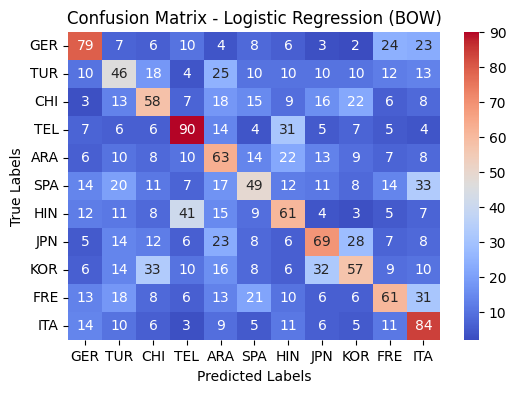

Logistic Regression (TF-IDF) - Overall Metrics:
- Accuracy: 0.6470
- Precision (Macro): 0.6480
- Recall (Macro): 0.6500
- F1 (Macro): 0.6464

Logistic Regression (TF-IDF) - Metrics by Label:
Label  Precision   Recall  F1 Score
  GER   0.710526 0.784884  0.745856
  TUR   0.564767 0.648810  0.603878
  CHI   0.636364 0.680000  0.657459
  TEL   0.657754 0.687151  0.672131
  ARA   0.607595 0.564706  0.585366
  SPA   0.679245 0.551020  0.608451
  HIN   0.570000 0.647727  0.606383
  JPN   0.691011 0.661290  0.675824
  KOR   0.654088 0.517413  0.577778
  FRE   0.711111 0.663212  0.686327
  ITA   0.645503 0.743902  0.691218


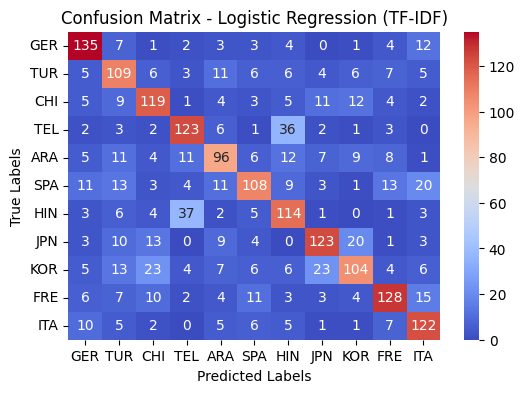

=========================SVM=============================
SVM (BOW) - Overall Metrics:
- Accuracy: 0.3545
- Precision (Macro): 0.3560
- Recall (Macro): 0.3571
- F1 (Macro): 0.3535

SVM (BOW) - Metrics by Label:
Label  Precision   Recall  F1 Score
  GER   0.432584 0.447674  0.440000
  TUR   0.295597 0.279762  0.287462
  CHI   0.280193 0.331429  0.303665
  TEL   0.426471 0.486034  0.454308
  ARA   0.302439 0.364706  0.330667
  SPA   0.347305 0.295918  0.319559
  HIN   0.345550 0.375000  0.359673
  JPN   0.395480 0.376344  0.385675
  KOR   0.350649 0.268657  0.304225
  FRE   0.396947 0.269430  0.320988
  ITA   0.342995 0.432927  0.382749


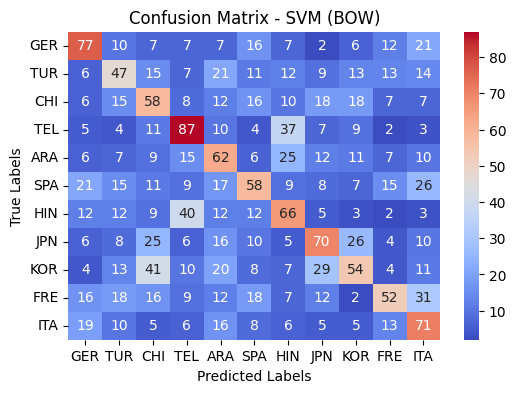

SVM (TF-IDF) - Overall Metrics:
- Accuracy: 0.6303
- Precision (Macro): 0.6356
- Recall (Macro): 0.6330
- F1 (Macro): 0.6312

SVM (TF-IDF) - Metrics by Label:
Label  Precision   Recall  F1 Score
  GER   0.714286 0.726744  0.720461
  TUR   0.516908 0.636905  0.570667
  CHI   0.586207 0.680000  0.629630
  TEL   0.708075 0.636872  0.670588
  ARA   0.562130 0.558824  0.560472
  SPA   0.656442 0.545918  0.596100
  HIN   0.550926 0.676136  0.607143
  JPN   0.704819 0.629032  0.664773
  KOR   0.625000 0.522388  0.569106
  FRE   0.729412 0.642487  0.683196
  ITA   0.637363 0.707317  0.670520


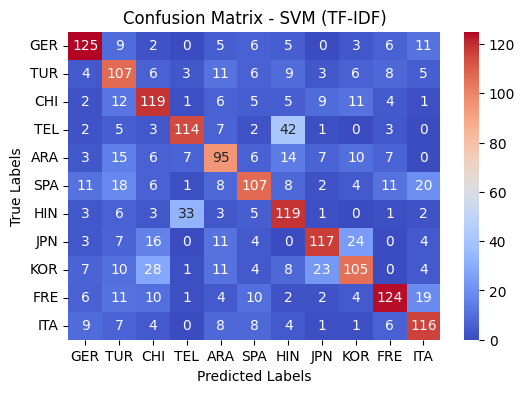

In [ ]:
mapping_list = {'GER' :0, 'TUR':1, 'CHI':2, 'TEL': 3, 'ARA' : 4, 'SPA' :5, 'HIN':6, 'JPN': 7, 'KOR':8, 'FRE':9, 'ITA':10}

X = df['text']
y = df['country_code'].map(mapping_list)

# Split data
train_bow, test_bow, y_train, y_test = train_test_split(vectorizer_BOW.fit_transform(X), y, test_size = 0.2, random_state = 42)
train_tf_idf , test_tf_idf , y_train, y_test = train_test_split(vectorizer_TF_IDF.fit_transform(X), y, test_size = 0.2, random_state = 42)

print('========================= Without Features=============================')

# Entraînement et évaluation des modèles
for model_name, model in models.items():

    print('========================='+model_name+'=============================')

    # ********************* Entraînement avec Bag-of-Words *********************
    evaluate_model_performance_detailed(mapping_list, model, model_name, "BOW", train_bow, test_bow, y_train, y_test)
    display_confusion_matrix(mapping_list, model, model_name, "BOW", test_bow, y_test)

    # *********************** Entraînement avec TF-IDF *************************
    evaluate_model_performance_detailed(mapping_list, model, model_name, "TF-IDF", train_tf_idf, test_tf_idf, y_train, y_test)
    display_confusion_matrix(mapping_list, model, model_name, "TF-IDF", test_tf_idf, y_test)

- Ces résultats mettent en évidence l'impact significatif de la méthode de prétraitement sur les performances des modèles. La méthode TF-IDF semble produire de bien meilleurs résultats que BOW pour les deux modèles testés.
- Nous avons donc décidé d’opter pour la méthode de prétraitement TF-IDF pour la suite.


## With features

In [ ]:
features= ['punctuation_frequency', 'stopword_frequency', 'spelling_errors']
#features= ['stopword_frequency', 'spelling_errors']
#features= ['punctuation_frequency','spelling_errors']
#features= ['spelling_errors']
#features= ['length_text', 'punctuation_frequency', 'stopword_frequency', 'spelling_errors']

=========================All Features=============================
=========================Logistic Regression=============================
Logistic Regression (TF-IDF) - Overall Metrics:
- Accuracy: 0.6081
- Precision (Macro): 0.6101
- Recall (Macro): 0.6114
- F1 (Macro): 0.6091

Logistic Regression (TF-IDF) - Metrics by Label:
Label  Precision   Recall  F1 Score
  GER   0.691011 0.715116  0.702857
  TUR   0.523810 0.589286  0.554622
  CHI   0.603175 0.651429  0.626374
  TEL   0.625698 0.625698  0.625698
  ARA   0.600000 0.582353  0.591045
  SPA   0.641892 0.484694  0.552326
  HIN   0.578680 0.647727  0.611260
  JPN   0.626374 0.612903  0.619565
  KOR   0.527919 0.517413  0.522613
  FRE   0.627778 0.585492  0.605898
  ITA   0.664773 0.713415  0.688235


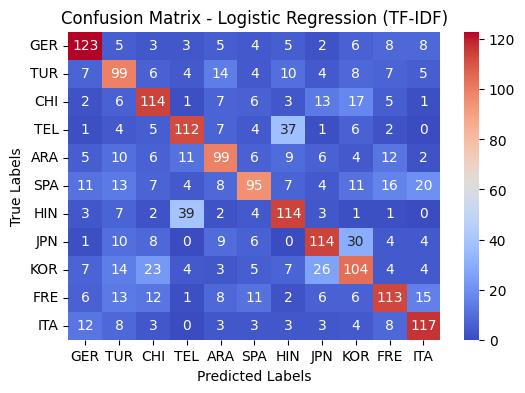

=========================SVM=============================


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



SVM (TF-IDF) - Overall Metrics:
- Accuracy: 0.1692
- Precision (Macro): 0.1583
- Recall (Macro): 0.1704
- F1 (Macro): 0.1389

SVM (TF-IDF) - Metrics by Label:
Label  Precision   Recall  F1 Score
  GER   0.136253 0.325581  0.192110
  TUR   0.100977 0.184524  0.130526
  CHI   0.138249 0.171429  0.153061
  TEL   0.136364 0.050279  0.073469
  ARA   0.252830 0.394118  0.308046
  SPA   0.225806 0.071429  0.108527
  HIN   0.212766 0.056818  0.089686
  JPN   0.166667 0.010753  0.020202
  KOR   0.210654 0.432836  0.283388
  FRE   0.000000 0.000000  0.000000
  ITA   0.161111 0.176829  0.168605


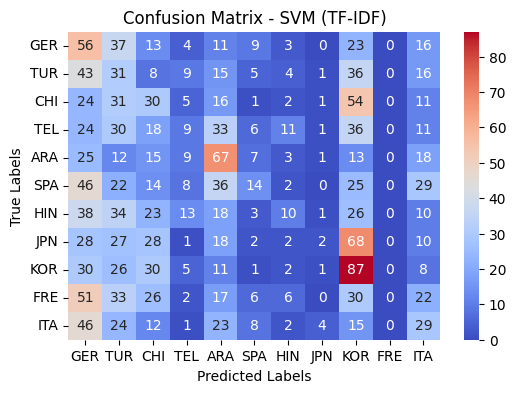

In [ ]:
mapping_list = {'GER' :0, 'TUR':1, 'CHI':2, 'TEL': 3, 'ARA' : 4, 'SPA' :5, 'HIN':6, 'JPN': 7, 'KOR':8, 'FRE':9, 'ITA':10}

X = df['text']


# BOW
X_bow = vectorizer_BOW.fit_transform(X)
# Numerical features
X_train_numeric_bow = df[features].values
# Combine text and numerical features
X_train_combined_bow = np.hstack((X_bow.toarray(), X_train_numeric_bow))

#TF-IDF
X_tf_idf = vectorizer_TF_IDF.fit_transform(X)
# Numerical features
X_train_numeric_tf_idf = df[features].values
# Combine text and numerical features
X_train_combined_tf_idf = np.hstack((X_tf_idf.toarray(), X_train_numeric_tf_idf))

y = df['country_code'].map(mapping_list)

# Split data
train_bow, test_bow, y_train, y_test = train_test_split(X_train_combined_bow, y, test_size = 0.2, random_state = 42)
train_tf_idf , test_tf_idf , y_train, y_test = train_test_split(X_train_combined_tf_idf, y, test_size = 0.2, random_state = 42)

print('=========================All Features=============================')

# Entraînement et évaluation des modèles
for model_name, model in models.items():

    print('========================='+model_name+'=============================')

    # ********************* Entraînement avec Bag-of-Words *********************
    #evaluate_model_performance_detailed(mapping_list, model, model_name, "BOW", train_bow, test_bow, y_train, y_test)
    #display_confusion_matrix(mapping_list, model, model_name, "BOW", test_bow, y_test)

    # *********************** Entraînement avec TF-IDF *************************
    evaluate_model_performance_detailed(mapping_list, model, model_name, "TF-IDF", train_tf_idf, test_tf_idf, y_train, y_test)
    display_confusion_matrix(mapping_list, model, model_name, "TF-IDF", test_tf_idf, y_test)

**Analyse et conclusion:**

- L'ajout de features supplémentaires a finalement conduit à une dégradation des performances du modèle, avec des résultats qui n'ont pas répondu à nos attentes. De plus, cette approche a considérablement augmenté le temps d'entraînement.
- Par conséquent, nous avons décidé de ne pas poursuivre cette direction et de clôturer cette piste d'amélioration.
